<a href="https://colab.research.google.com/github/deepacefic/Covid19-Dashboard/blob/master/forecasting_with_SARIMA_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from sklearn import svm
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
%matplotlib inline

Using TensorFlow backend.


In [ ]:
# loading the datsets
d = pd.read_csv(r'/content/covid_19_dataL.csv')
d.head()

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,1,01/22/2020,Anhui,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
1,2,01/22/2020,Beijing,Mainland China,1/22/2020 17:00,14.0,0.0,0.0
2,3,01/22/2020,Chongqing,Mainland China,1/22/2020 17:00,6.0,0.0,0.0
3,4,01/22/2020,Fujian,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
4,5,01/22/2020,Gansu,Mainland China,1/22/2020 17:00,0.0,0.0,0.0


In [ ]:
#Group by :It is like pivid functionality
d2 = d.groupby(["ObservationDate","Country/Region","Province/State"])[['ObservationDate','Province/State','Country/Region','Confirmed','Deaths','Recovered']]
d2.head()

,ObservationDate,Province/State,Country/Region,Confirmed,Deaths,Recovered
0,01/22/2020,Anhui,Mainland China,1.0,0.0,0.0
1,01/22/2020,Beijing,Mainland China,14.0,0.0,0.0
2,01/22/2020,Chongqing,Mainland China,6.0,0.0,0.0
3,01/22/2020,Fujian,Mainland China,1.0,0.0,0.0
4,01/22/2020,Gansu,Mainland China,0.0,0.0,0.0
...,...,...,...,...,...,...
42987,06/15/2020,Zacatecas,Mexico,550.0,58.0,324.0
42988,06/15/2020,Zakarpattia Oblast,Ukraine,1680.0,42.0,686.0
42989,06/15/2020,Zaporizhia Oblast,Ukraine,529.0,16.0,335.0
42990,06/15/2020,Zhejiang,Mainland China,1268.0,1.0,1267.0


we will forecast India's growing cases with SARIMA models

In [ ]:
d.rename(columns={'Country/Region':'Country'},inplace=True)
d.query('Country=="India"').groupby("ObservationDate")[["Confirmed","Deaths","Recovered"]].sum().reset_index()

,ObservationDate,Confirmed,Deaths,Recovered
0,01/30/2020,1.0,0.0,0.0
1,01/31/2020,1.0,0.0,0.0
2,02/01/2020,1.0,0.0,0.0
3,02/02/2020,2.0,0.0,0.0
4,02/03/2020,3.0,0.0,0.0
...,...,...,...,...
133,06/11/2020,297535.0,8498.0,147195.0
134,06/12/2020,297535.0,8498.0,147195.0
135,06/13/2020,308993.0,8884.0,154330.0
136,06/14/2020,320922.0,9195.0,162379.0


In [ ]:
from fbprophet import Prophet
daily_cases = d.loc[(d["Country"]=="India") , ["ObservationDate","Confirmed"]]
daily_cases['ObservationDate'] = pd.to_datetime(daily_cases['ObservationDate'],dayfirst=True)
print(daily_cases.shape)
daily_cases.head()

(348, 2)


,ObservationDate,Confirmed
430,2020-01-30,1.0
491,2020-01-31,1.0
547,2020-01-02,1.0
607,2020-02-02,2.0
672,2020-03-02,3.0


In [ ]:
daily_cases.columns=['ds', 'y']

In [ ]:
y = daily_cases.set_index(['ds']).sort_values(by="ds")
y.head()

,y
ds,
2020-01-02,1.0
2020-01-03,3.0
2020-01-04,1998.0
2020-01-05,37257.0
2020-01-06,198370.0


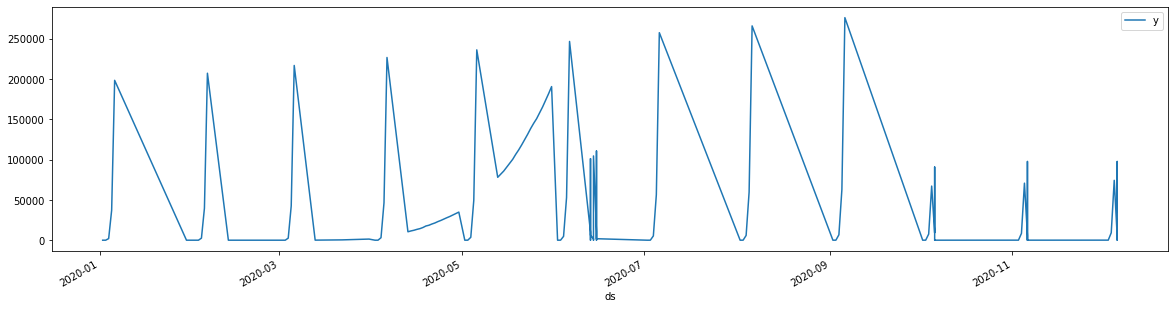

In [ ]:
y.plot(figsize=(20,5))
plt.show()

In [ ]:
import warnings
import itertools
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [ ]:
import statsmodels.api as sm
for param in pdq:
    for param_seasonal in seasonal_pdq:
        model = sm.tsa.statespace.SARIMAX(y,order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
        results = model.fit()
        print('ARIMA{}x{}12 - AIC:{}'.format(param,param_seasonal,results.aic))

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequ

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:8537.250031136558
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:8204.596472030975
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:8353.552405291965
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:7918.284565018257
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:8218.125541224268
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:8182.85973001213


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:7992.116143917598


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:7905.465522928476
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:8453.224400859988
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:8130.608222411256
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:8302.838437934946


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:7875.03601672245
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:8176.233032331013


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:8121.03326535124


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:7969.545076406099
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:7873.656027528029
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:8529.32714785884
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:8198.65360917797
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:8448.94594329097


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided,

ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:7946.576699237356
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:8222.116508646743


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:8199.51508222582
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:8040.485938997725


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:7926.566823056084
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:8361.632851627157
ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:8043.778082617008


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:8299.281205040978


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:7849.341887202343
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:8092.0084075305185


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:8043.878442212377


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:7948.648858586903


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



ARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:7851.257369080118
ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:8449.876315977825
ARIMA(1, 0, 0)x(0, 0, 1, 12)12 - AIC:8127.714577149503
ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:8326.910461461694


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



ARIMA(1, 0, 0)x(0, 1, 1, 12)12 - AIC:7887.382090256488
ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:8126.6719502674705


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:8122.527266771205


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:7938.722675946269


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



ARIMA(1, 0, 0)x(1, 1, 1, 12)12 - AIC:7888.351749699074
ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:8382.097952538712
ARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:8064.823957943412


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



ARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:8304.577370250168


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



ARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:7845.407529045582
ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:8088.917973506932


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:8065.799375815624


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:7924.735261687327


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



ARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:7847.362989297835
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:8475.908810708159
ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:8149.279107903309
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:8409.863937987151


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



ARIMA(1, 1, 0)x(0, 1, 1, 12)12 - AIC:7939.310642299919
ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:8149.225901727422


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:8149.228592344309


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:7996.483367336291


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



ARIMA(1, 1, 0)x(1, 1, 1, 12)12 - AIC:7941.171464705169
ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:8359.976998644897


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



ARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:8041.904735640861


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:8283.074558788827
ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:7840.684719470208
ARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:8065.623739545958


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



ARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:8042.345635541777


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:7929.299229751905


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:7842.639536539859


In [ ]:
model = sm.tsa.statespace.SARIMAX(y,
                                order=(0, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = model.fit()
print(results.summary().tables[1])

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8027      0.060    -13.454      0.000      -0.920      -0.686
ar.S.L12      -0.0255      0.156     -0.164      0.870      -0.331       0.280
ma.S.L12      -0.9929      0.034    -28.818      0.000      -1.060      -0.925
sigma2      4.249e+09    8.6e-12   4.94e+20      0.000    4.25e+09    4.25e+09


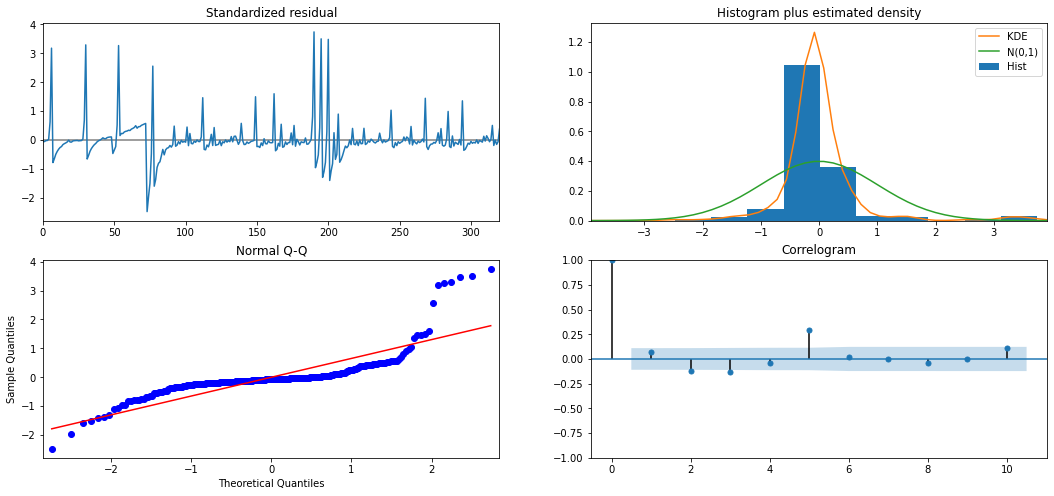

In [ ]:
results.plot_diagnostics(figsize=(18, 8))
plt.show()

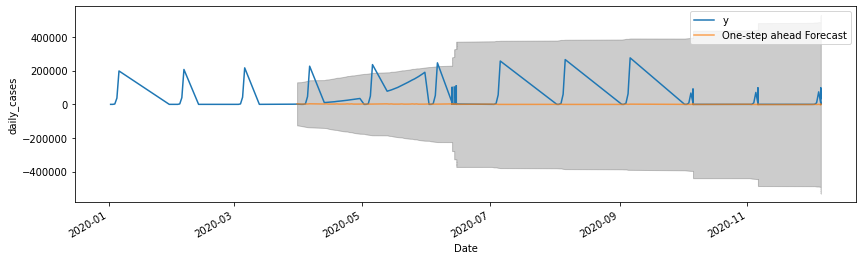

In [ ]:
pred = results.get_prediction(start=pd.to_datetime('2020-3-31'), dynamic=True)
pred_ci = pred.conf_int()
ax = y['2020':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 4))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('daily_cases')
plt.legend()
plt.show()

In [ ]:
import numpy as np
import pandas as pd
from fbprophet import Prophet
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred):
  y_true, y_pred = np.array(y_true), np.array(y_pred)
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

MSE = mean_squared_error(y_true=y['2020-3-31':],
y_pred=pred.predicted_mean)
MAE = mean_absolute_error(y_true=y['2020-3-31':],
y_pred=pred.predicted_mean)
MAPE = mean_absolute_percentage_error(y_true=y['2020-3-31':],
y_pred=pred.predicted_mean)
print ('MSE :',MSE)
print ('MAE :',MAE)
print ('MAEP', MAPE, '%')
y_pred = pred.predicted_mean ;y_true = y['2020-3-31':]

MSE : 2805311490.076694
MAE : 22768.27357591518
MAEP 1562.863980757251 %


In [ ]:
y_forecasted = pred.predicted_mean
y_forecasted.head(60)

ds
2020-03-31    3141.117958
2020-04-02    1685.702578
2020-04-03    1667.196936
2020-04-04    1698.684872
2020-04-05    2028.490380
2020-04-06    3352.296978
2020-04-13    2017.710122
2020-04-14    3176.900263
2020-04-15    1613.805341
2020-04-16    1525.269760
2020-04-17    1526.955120
2020-04-18    1790.185492
2020-04-19    2920.030814
2020-04-20    1503.060631
2020-04-21    1487.223848
2020-04-22    1519.593151
2020-04-23    1843.606514
2020-04-24    3134.550732
2020-04-25    1837.136556
2020-04-26    2968.511031
2020-04-27    1449.420393
2020-04-28    1365.699621
2020-04-29    1368.286843
2020-04-30    1630.591966
2020-05-02    2779.853081
2020-05-03    1361.901087
2020-05-04    1345.996146
2020-05-05    1378.342941
2020-05-06    1702.504224
2020-05-13    2994.287679
2020-05-14    1695.924189
2020-05-15    2828.009019
2020-05-16    1307.794602
2020-05-17    1223.950870
2020-05-18    1226.515060
2020-05-19    1488.843813
2020-05-20    2637.609088
2020-05-21    1219.682167
2020-05-2

In [ ]:
y_true= y['2020-3-31':].head(48)
y_true

,y
ds,
2020-03-31,1397.0
2020-04-02,3.0
2020-04-03,28.0
2020-04-04,3082.0
2020-04-05,46437.0
2020-04-06,226713.0
2020-04-13,10453.0
2020-04-14,11487.0
2020-04-15,12322.0


In [ ]:
pred_ci.head(48)

,lower y,upper y
ds,,
2020-03-31,-124714.848057,130997.083973
2020-04-02,-128665.123276,132036.528431
2020-04-03,-131132.772556,134467.166428
2020-04-04,-133507.529567,136904.899311
2020-04-05,-135543.721982,139600.702741
2020-04-06,-136548.194494,143252.788450
2020-04-13,-140175.788257,144211.208502
2020-04-14,-141276.740774,147630.541299
2020-04-15,-145061.286049,148288.896731
